In [1]:
import os
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import numpy as np
from shutil import copy2   # để copy file mask sang thư mục mới
from skimage.morphology import dilation, disk

# ====== ĐƯỜNG DẪN THƯ MỤC ======
DATA_ROOT = Path("/media/pphong/D:/ML & DL/xu li anh/XLA_CK/data")
IMAGES_FULL = DATA_ROOT / "images"
MASK_FULL = Path("/media/pphong/D:/ML & DL/xu li anh/XLA_CK/data/annotations/annotations/trimaps")

A_FOLDER = Path("/media/pphong/D:/ML & DL/xu li anh/XLA_CK/images")

SAVE_MASK_B = Path("/media/pphong/D:/ML & DL/xu li anh/XLA_CK/mask_B")
SAVE_MASK_B.mkdir(exist_ok=True)   # tạo thư mục lưu mask B nếu chưa có


In [2]:
# ====== KIỂM TRA ẢNH TỒN TẠI MASK ======
B = []   # danh sách chứa (img_name, mask_path)

images_A = sorted([f for f in os.listdir(A_FOLDER) if f.endswith(".jpg")])

for img_name in images_A:
    base_name = os.path.splitext(img_name)[0]
    mask_name = base_name + ".png"     # mask luôn .png
    
    mask_path = MASK_FULL / mask_name
    
    if mask_path.exists():
        B.append((img_name, mask_path))  # lưu cả tên ảnh + đường dẫn mask
        copy2(mask_path, SAVE_MASK_B / mask_name)  # copy mask sang thư mục riêng

print(f"Tổng số ảnh trong A: {len(images_A)}")
print(f"Số ảnh có ground truth tương ứng tập B: {len(B)}")


Tổng số ảnh trong A: 58
Số ảnh có ground truth tương ứng tập B: 58


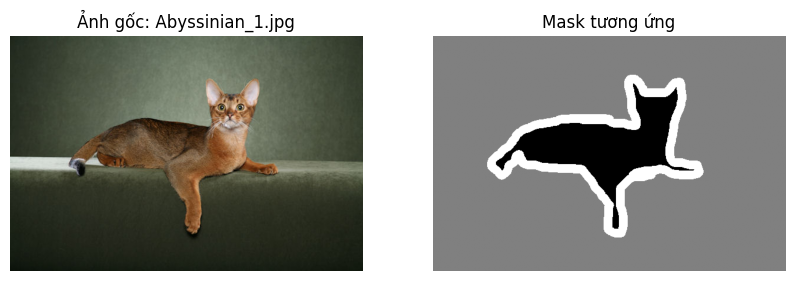

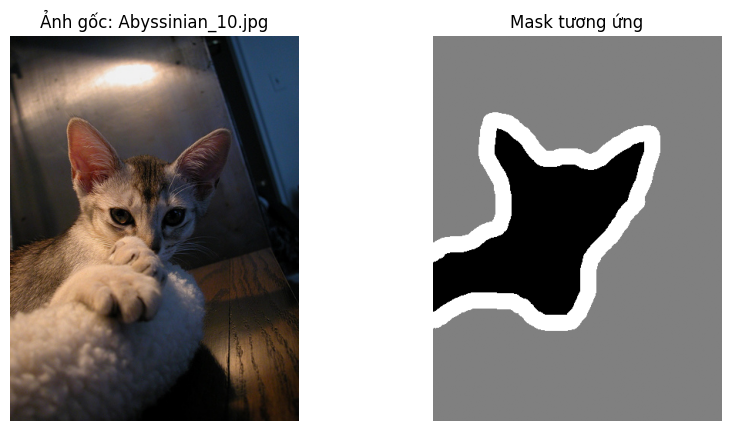

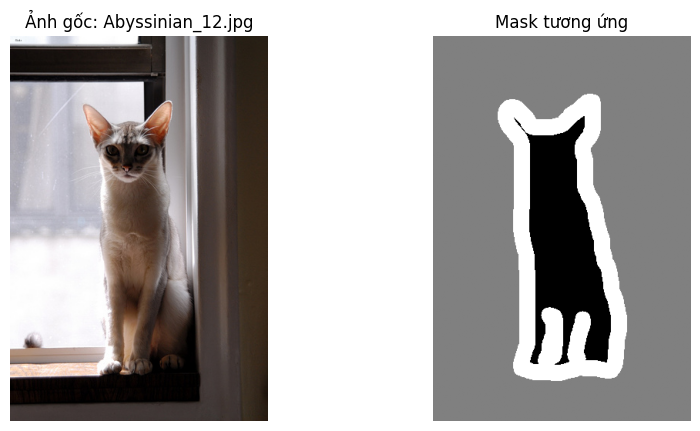

In [3]:
# ====== HIỂN THỊ ẢNH + MASK ======
for img_name, mask_path in B[:3]:  # hiển thị 3 cặp đầu để tránh quá nhiều
    image_path = A_FOLDER / img_name
    
    img = cv2.imread(str(image_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    mask = cv2.imread(str(mask_path), 0)

    plt.figure(figsize=(10,5))

    plt.subplot(1,2,1)
    plt.title(f"Ảnh gốc: {img_name}")
    plt.imshow(img)
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.title("Mask tương ứng")
    plt.imshow(mask, cmap='gray')
    plt.axis("off")

    plt.show()


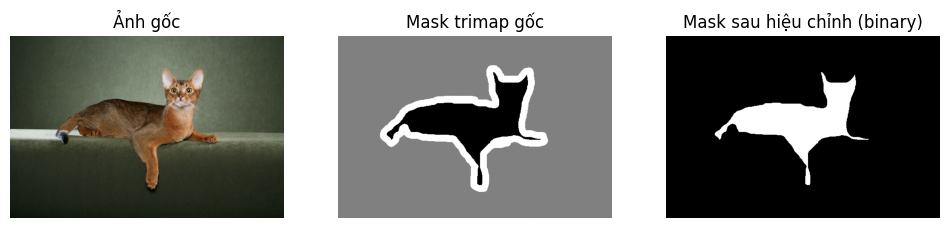

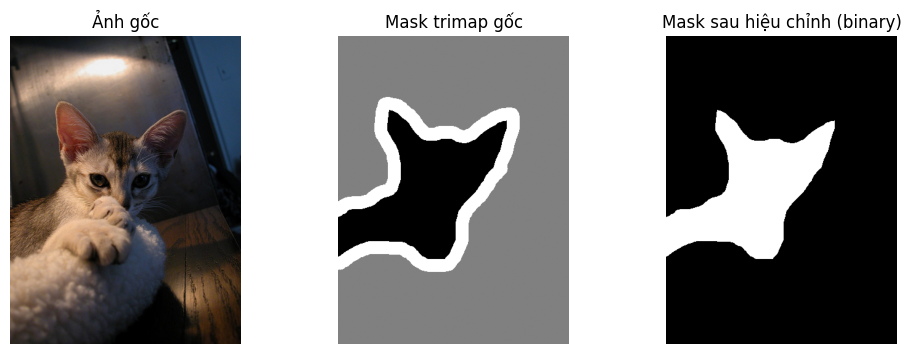

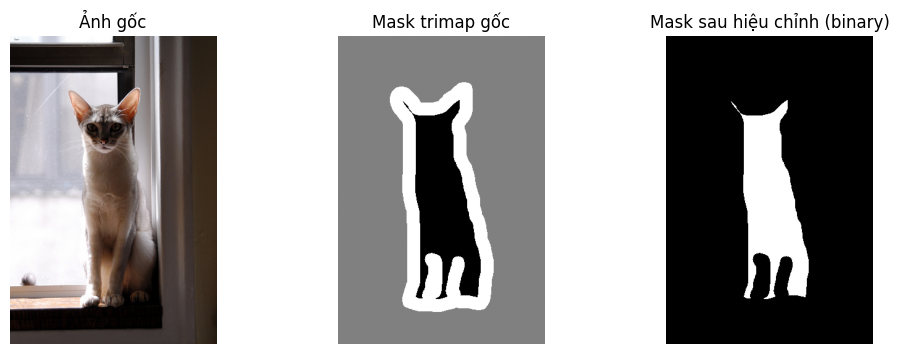

In [4]:
# ====== THƯ MỤC LƯU MASK NHỊ PHÂN (GROUND TRUTH SAU HIỆU CHỈNH) ======
MASK_BIN_FOLDER = Path("/media/pphong/D:/ML & DL/xu li anh/XLA_CK/mask_binary")
MASK_BIN_FOLDER.mkdir(exist_ok=True)

# ====== HIỆU CHỈNH MASK (CHỈ GIỮ PIXEL = 1) ======
examples = []   # lưu ví dụ để minh họa

for img_name, mask_path in B:
    
    # đọc mask gốc
    mask = cv2.imread(str(mask_path), 0)

    # giữ lại miền interior (giá trị 1)
    mask_binary = np.where(mask == 1, 1, 0).astype(np.uint8)

    # lưu mask nhị phân
    base_name = os.path.splitext(img_name)[0]
    save_path = MASK_BIN_FOLDER / (base_name + "_bin.png")
    cv2.imwrite(str(save_path), mask_binary * 255)  # convert 0–1 → 0–255

    # lưu 3 ví dụ để minh họa
    if len(examples) < 3:
        img = cv2.imread(str(A_FOLDER / img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        examples.append((img, mask, mask_binary))

# ====== MINH HỌA MỘT VÀI KẾT QUẢ ======
for img, mask, mask_bin in examples:
    
    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.title("Ảnh gốc")
    plt.imshow(img)
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("Mask trimap gốc")
    plt.imshow(mask, cmap='gray')
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.title("Mask sau hiệu chỉnh (binary)")
    plt.imshow(mask_bin, cmap='gray')
    plt.axis("off")

    plt.show()


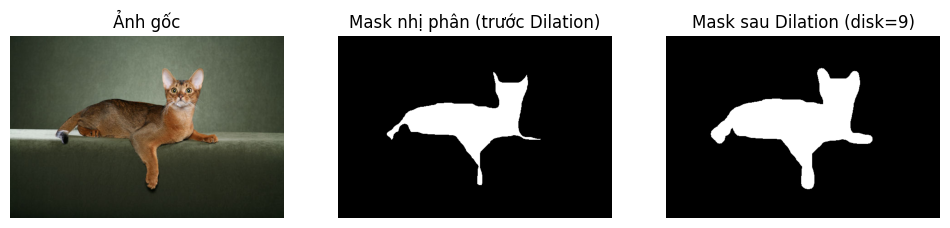

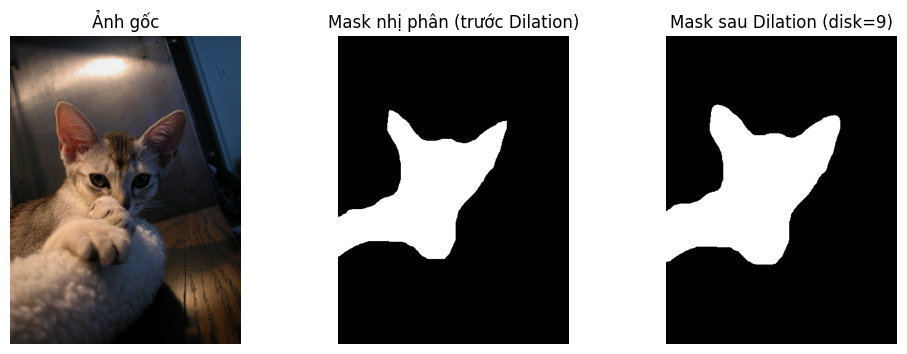

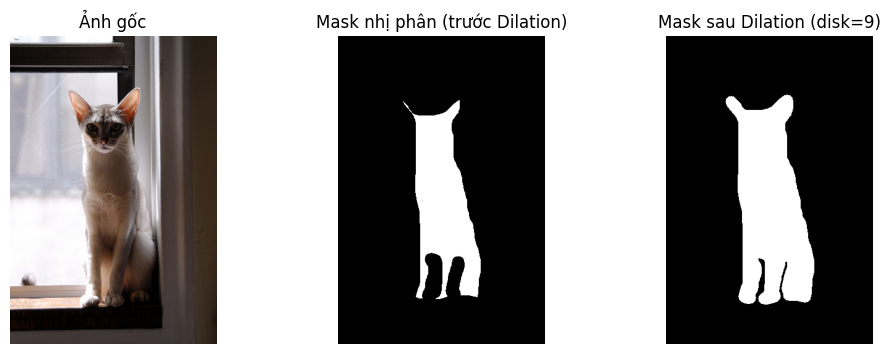

In [5]:
# Thư mục lưu mask sau khi Dilation
MASK_DILATION_FOLDER = Path("/media/pphong/D:/ML & DL/xu li anh/XLA_CK/mask_dilated")
MASK_DILATION_FOLDER.mkdir(exist_ok=True)

# --- Hàm tự tạo kernel hình đĩa ---
def create_disk(radius):
    """
    Tạo kernel dạng hình đĩa bán kính R (thay thế skimage.morphology.disk)
    """
    size = radius * 2 + 1
    y, x = np.ogrid[-radius:radius+1, -radius:radius+1]
    mask = (x**2 + y**2 <= radius**2)
    return mask.astype(np.uint8)

# --- Tạo kernel dilation ---
selem = create_disk(9)   # disk radius = 9

examples_dilation = []   # lưu ví dụ minh họa

# Lặp qua các mask đã được nhị phân hóa
for img_name, mask_path in B:
    
    base_name = os.path.splitext(img_name)[0]
    bin_mask_path = MASK_BIN_FOLDER / f"{base_name}_bin.png"

    # Đọc mask nhị phân (0–255)
    mask_bin = cv2.imread(str(bin_mask_path), 0)

    if mask_bin is None:
        print(f" Không tìm thấy mask nhị phân cho: {img_name}")
        continue

    # Chuyển về 0–1 cho đúng dạng nhị phân
    mask_bin_01 = (mask_bin > 127).astype(np.uint8)

    # Áp dụng Dilation
    mask_dilated = dilation(mask_bin_01, selem)

    # Lưu mask sau Dilation (0–255)
    save_path = MASK_DILATION_FOLDER / f"{base_name}_dilated.png"
    cv2.imwrite(str(save_path), mask_dilated.astype(np.uint8) * 255)

    # Lưu 3 ví dụ để minh họa
    if len(examples_dilation) < 3:
        img = cv2.imread(str(A_FOLDER / img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        examples_dilation.append((img, mask_bin_01, mask_dilated))


# MINH HỌA KẾT QUẢ

for img, mask_bin, mask_dil in examples_dilation:
    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.title("Ảnh gốc")
    plt.imshow(img)
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("Mask nhị phân (trước Dilation)")
    plt.imshow(mask_bin, cmap='gray')
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.title("Mask sau Dilation (disk=9)")
    plt.imshow(mask_dil, cmap='gray')
    plt.axis("off")

    plt.show()

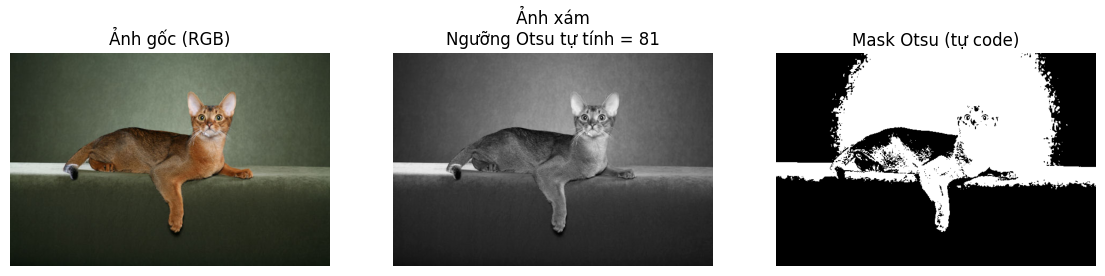

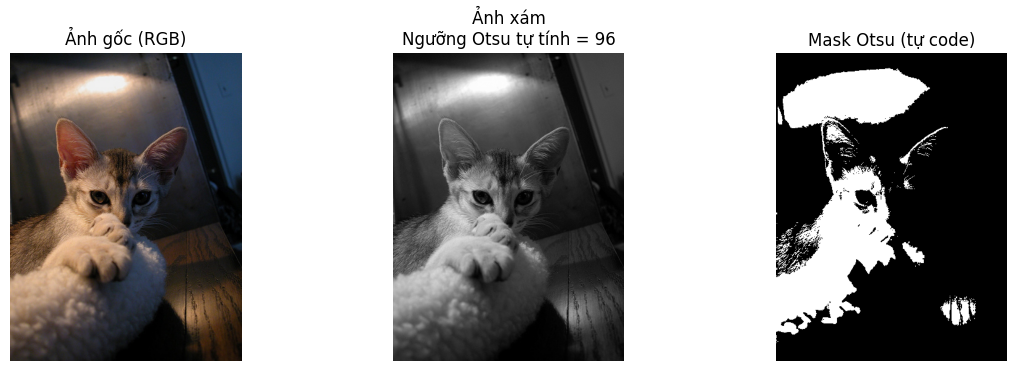

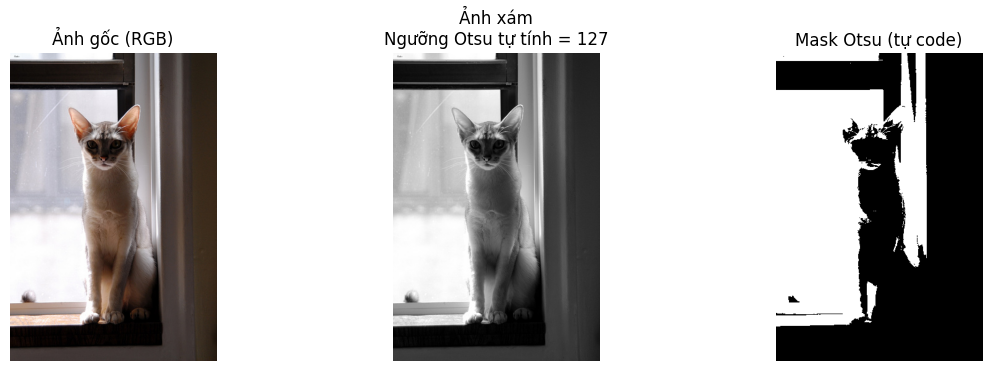

In [6]:

# --- Hàm tự tính ngưỡng Otsu ---
def otsu_threshold_manual(image):
    # Tính histogram (256 mức xám)
    hist = np.bincount(image.flatten(), minlength=256)
    total = image.size

    # Tổng trọng số và tổng cường độ
    sum_total = np.dot(np.arange(256), hist)

    sumB = 0       # tổng cường độ lớp background (từ 0..t)
    wB = 0         # tổng số pixel lớp background
    max_variance = 0
    threshold = 0

    for t in range(256):
        wB += hist[t]
        if wB == 0:
            continue

        wF = total - wB
        if wF == 0:
            break

        sumB += t * hist[t]

        mB = sumB / wB              # mean background
        mF = (sum_total - sumB) / wF  # mean foreground

        # Between-class variance
        variance = wB * wF * (mB - mF) ** 2

        if variance > max_variance:
            max_variance = variance
            threshold = t

    return threshold


# --- Thư mục lưu kết quả Otsu ---
MASK_OTSU_FOLDER = Path("/media/pphong/D:/ML & DL/xu li anh/XLA_CK/mask_otsu_manual")
MASK_OTSU_FOLDER.mkdir(exist_ok=True)

examples_otsu = []


# --- Áp dụng Otsu cho từng ảnh ---
for img_name, _ in B:
    image_path = A_FOLDER / img_name

    # Đọc ảnh grayscale
    img_gray = cv2.imread(str(image_path), 0)
    
    if img_gray is None:
        print(f"Không đọc được ảnh: {img_name}")
        continue

    # --- TÍNH NGƯỠNG OTSU THỦ CÔNG ---
    T = otsu_threshold_manual(img_gray)

    # --- Tạo mask ---
    mask_otsu = (img_gray >= T).astype(np.uint8) * 255

    # --- Lưu kết quả ---
    base_name = os.path.splitext(img_name)[0]
    save_path = MASK_OTSU_FOLDER / f"{base_name}_otsu_manual.png"
    cv2.imwrite(str(save_path), mask_otsu)

    # lưu 3 ví dụ minh họa
    if len(examples_otsu) < 3:
        img_rgb = cv2.imread(str(image_path))
        img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
        examples_otsu.append((img_rgb, img_gray, mask_otsu, T))

#kêt quả

for img_rgb, img_gray, mask_otsu, T in examples_otsu:
    plt.figure(figsize=(14,4))

    plt.subplot(1,3,1)
    plt.title("Ảnh gốc (RGB)")
    plt.imshow(img_rgb)
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title(f"Ảnh xám\nNgưỡng Otsu tự tính = {T}")
    plt.imshow(img_gray, cmap='gray')
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.title("Mask Otsu (tự code)")
    plt.imshow(mask_otsu, cmap='gray')
    plt.axis("off")

    plt.show()


/tmp/ipykernel_40711/3860492500.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_centers.append(float(centers[k]))


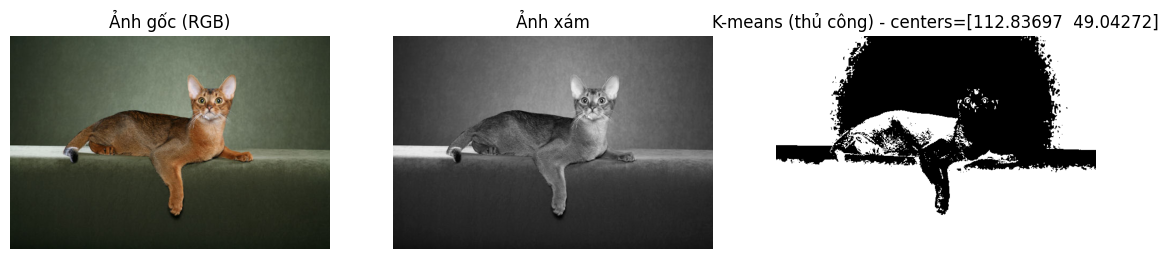

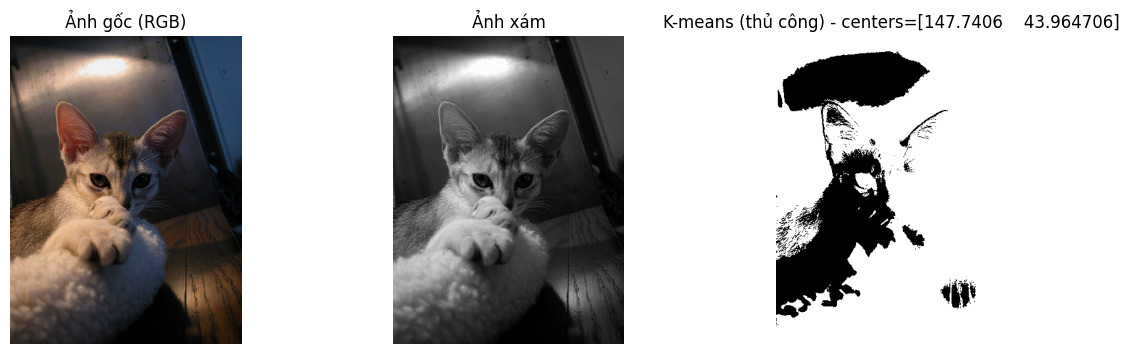

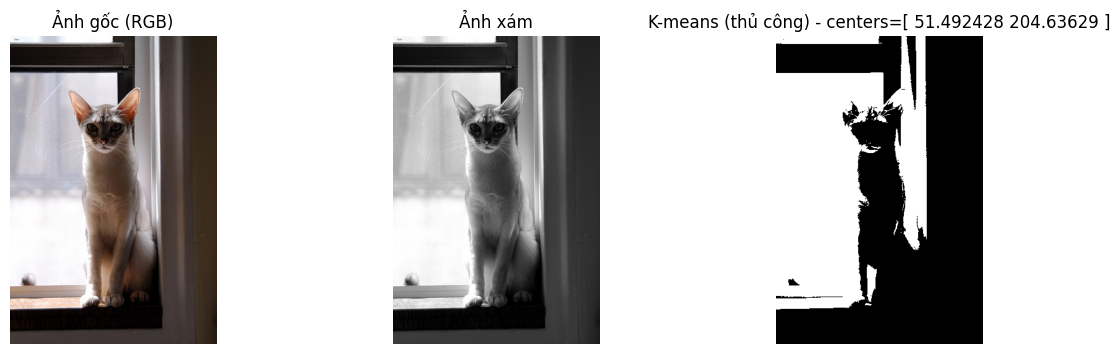

In [8]:

# --- Hàm K-means thủ công (k = 2) ---

def kmeans_manual(image, K=2, max_iter=50):
    pixels = image.reshape(-1, 1).astype(np.float32)

    # Khởi tạo tâm cụm
    np.random.seed(0)
    indices = np.random.choice(len(pixels), K, replace=False)
    centers = pixels[indices].astype(np.float32)   # shape (K,1)

    for _ in range(max_iter):

        # Tính khoảng cách tới tâm cụm
        distances = np.abs(pixels - centers.T)     # shape (N,K)

        # Gán nhãn
        labels = np.argmin(distances, axis=1)

        # Cập nhật tâm
        new_centers = []
        for k in range(K):
            if np.any(labels == k):
                # mean trả về float → đảm bảo đồng nhất
                new_centers.append(float(pixels[labels == k].mean()))
            else:
                # tránh cụm rỗng → giữ nguyên tâm cũ
                new_centers.append(float(centers[k]))

        # Đưa về dạng (K,1)
        new_centers = np.array(new_centers, dtype=np.float32).reshape(K, 1)

        # Kiểm tra hội tụ
        if np.allclose(centers, new_centers):
            break

        centers = new_centers.copy()

    return labels.reshape(image.shape), centers



# --- Thư mục lưu mask K-means ---
MASK_KMEANS_FOLDER = Path("/media/pphong/D:/ML & DL/xu li anh/XLA_CK/mask_kmeans_manual")
MASK_KMEANS_FOLDER.mkdir(exist_ok=True)

examples_kmeans = []


# --- Áp dụng K-means cho từng ảnh trong B ---
for img_name, _ in B:
    image_path = A_FOLDER / img_name

    # Đọc ảnh grayscale
    img_gray = cv2.imread(str(image_path), 0)
    if img_gray is None:
        print(f"⚠ Không đọc được ảnh: {img_name}")
        continue

    # --- Chạy K-means thủ công ---
    labels, centers = kmeans_manual(img_gray, K=2)

    # --- Chuyển labels về mask 0–255 ---
    mask_kmeans = (labels.astype(np.uint8) * 255)

    # --- Lưu kết quả ---
    base_name = os.path.splitext(img_name)[0]
    save_path = MASK_KMEANS_FOLDER / f"{base_name}_kmeans_manual.png"
    cv2.imwrite(str(save_path), mask_kmeans)

    # Lưu 3 ví dụ để minh họa
    if len(examples_kmeans) < 3:
        img_rgb = cv2.imread(str(image_path))
        img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
        examples_kmeans.append((img_rgb, img_gray, mask_kmeans, centers))



for img_rgb, img_gray, mask_km, centers in examples_kmeans:
    plt.figure(figsize=(14,4))

    plt.subplot(1,3,1)
    plt.title("Ảnh gốc (RGB)")
    plt.imshow(img_rgb)
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("Ảnh xám")
    plt.imshow(img_gray, cmap='gray')
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.title(f"K-means (thủ công) - centers={centers.flatten()}")
    plt.imshow(mask_km, cmap='gray')
    plt.axis("off")

    plt.show()
